In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing

In [2]:
df = pd.read_csv('exchange_rate.csv')


In [3]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [4]:
df['date'] = pd.to_datetime(df['date'],format='%d-%m-%Y %H:%M', errors='coerce')

In [5]:
df.head()

,date,Ex_rate
0,1990-01-01,0.7855
1,1990-01-02,0.7818
2,1990-01-03,0.7867
3,1990-01-04,0.7860
4,1990-01-05,0.7849


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     7588 non-null   datetime64[ns]
 1   Ex_rate  7588 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 118.7 KB


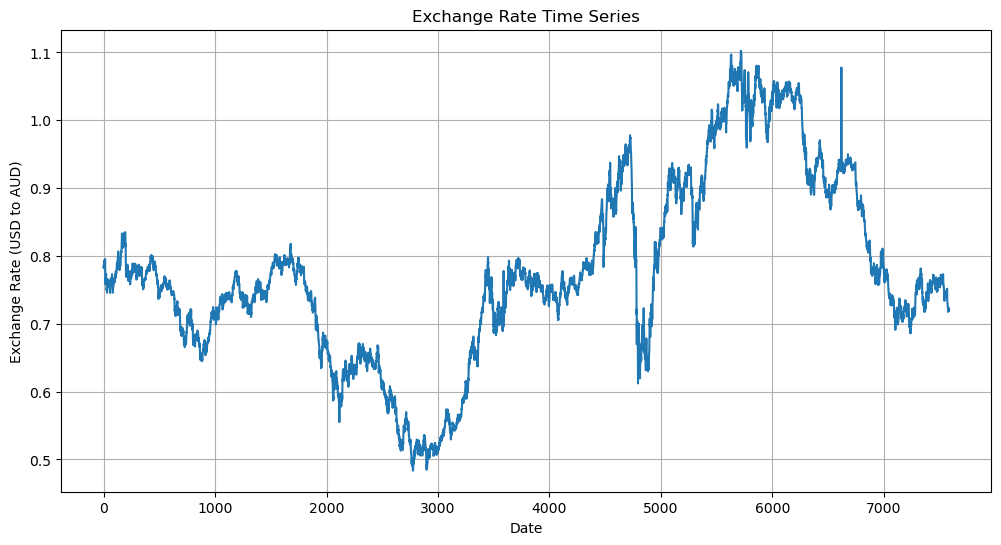

In [13]:
plt.figure(figsize=(12, 6))
df['Ex_rate'].plot(title='Exchange Rate Time Series')
plt.ylabel('Exchange Rate (USD to AUD)')
plt.xlabel('Date')
plt.grid(True)
plt.show() 

In [6]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [7]:
df.duplicated().sum()

0

<Axes: >

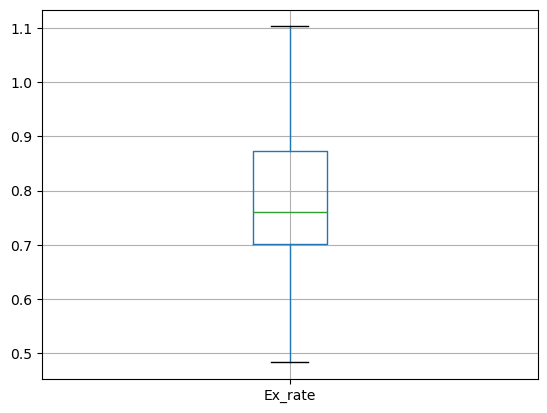

In [8]:
df.boxplot()

In [18]:
series = df['Ex_rate']

In [19]:
adf_result = adfuller(series)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')


ADF Statistic: -1.6650
p-value: 0.4492


In [20]:
## p value > 0.05 .Therefore it is non stationary

In [21]:
d_param = 0

In [23]:
series_diff = series.diff().dropna()
d_param = 1

In [24]:
adf_result_diff = adfuller(series_diff)

In [25]:
print(f'Differenced ADF p-value: {adf_result_diff[1]:.4f}')

Differenced ADF p-value: 0.0000


In [27]:
## Now it is < 0.05 .Therefore it is stationary

In [28]:
current_series = series_diff

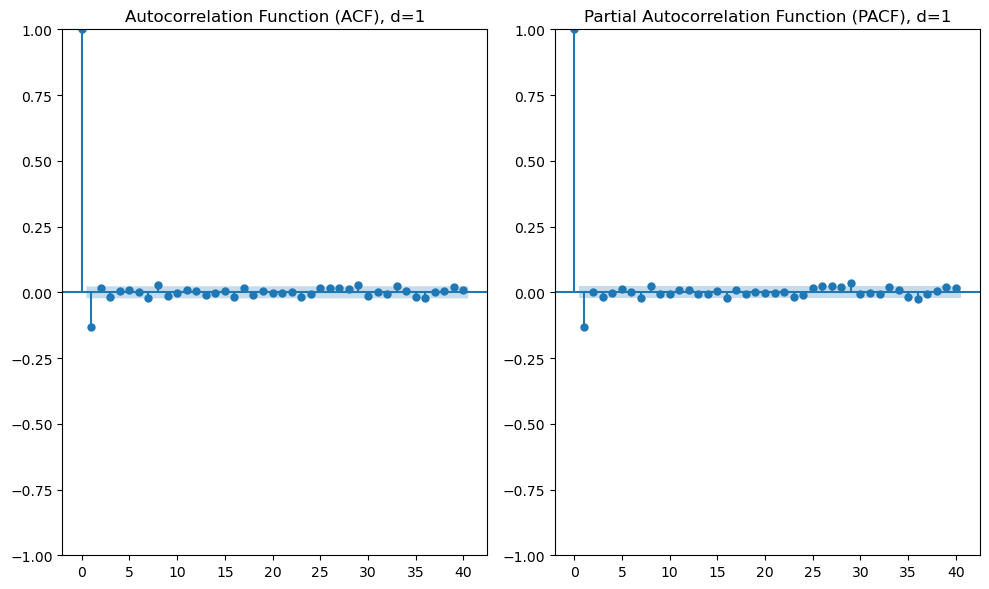

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
plot_acf(current_series, ax=axes[0], lags=40, title=f'Autocorrelation Function (ACF), d={d_param}')
plot_pacf(current_series, ax=axes[1], lags=40, title=f'Partial Autocorrelation Function (PACF), d={d_param}')
plt.tight_layout()
plt.show()

In [33]:
split_point = int(len(series) * 0.95) 
train, test = series.iloc[:split_point], series.iloc[split_point:]

In [34]:
arima_order = (1, d_param, 1)

In [37]:
arima_model = ARIMA(train, order=arima_order)
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7208
Model:                 ARIMA(1, 1, 1)   Log Likelihood               26570.025
Date:                Wed, 12 Nov 2025   AIC                         -53134.050
Time:                        17:41:27   BIC                         -53113.401
Sample:                             0   HQIC                        -53126.945
                               - 7208                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1185      0.046     -2.559      0.011      -0.209      -0.028
ma.L1         -0.0137      0.046     -0.295      0.768      -0.105       0.077
sigma2      3.675e-05   1.04e-07    353.589      0.0

In [38]:
start = len(train)
end = len(train) + len(test) - 1
arima_forecast = arima_fit.predict(start=start, end=end, dynamic=False)

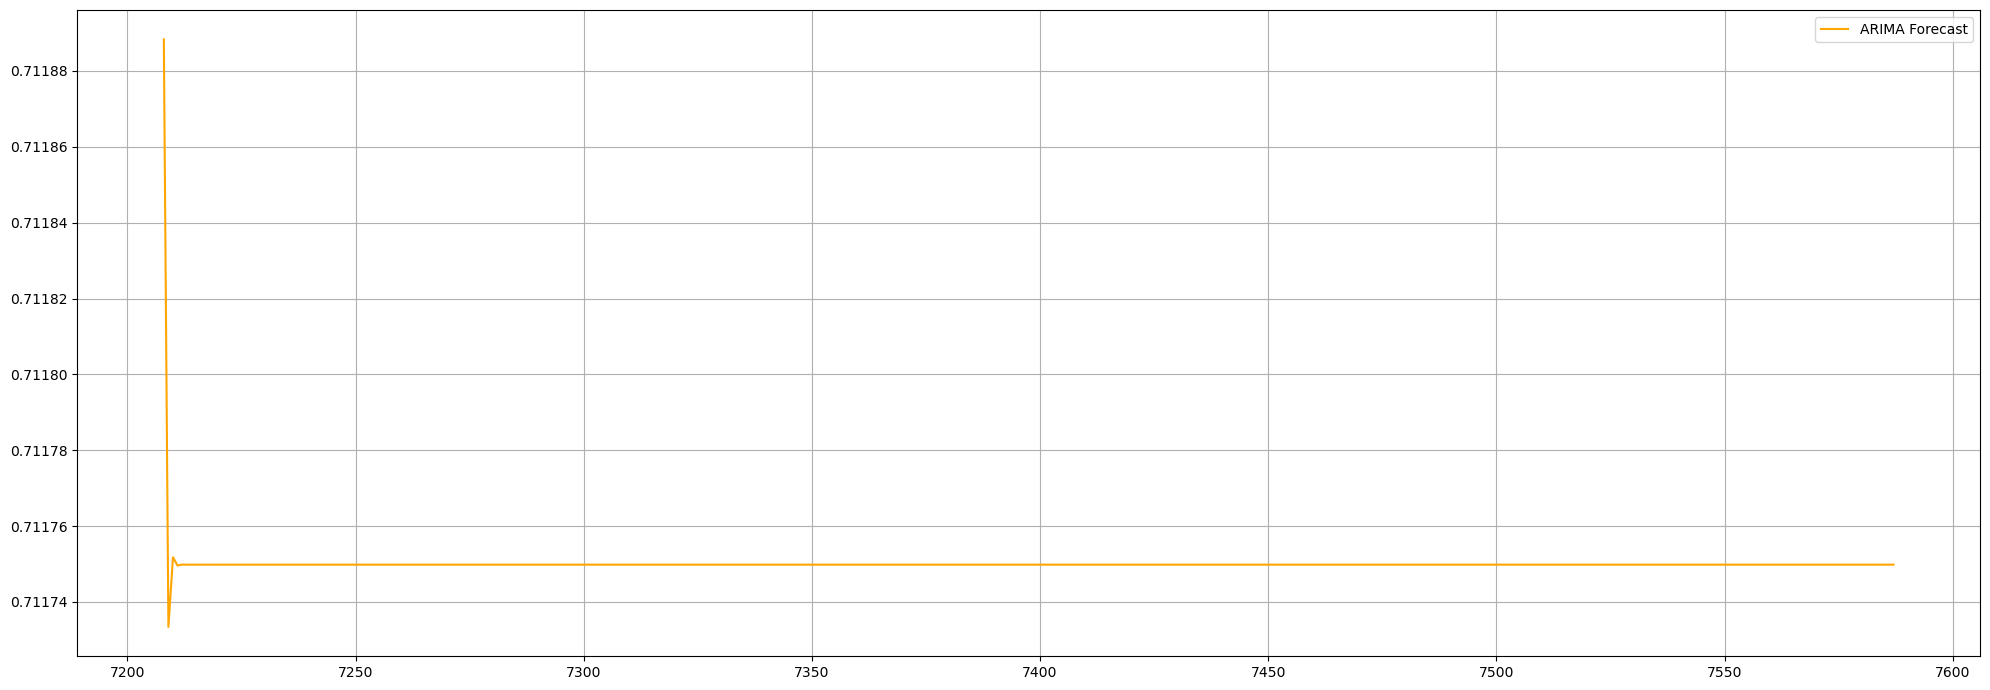

In [62]:
plt.figure(figsize=(20, 7))
plt.plot(arima_forecast, label='ARIMA Forecast', color='orange')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
actuals = test.values

In [47]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:

arima_mae = mean_absolute_error(actuals, arima_forecast.values)
arima_rmse = np.sqrt(mean_squared_error(actuals, arima_forecast.values))
arima_mape = mean_absolute_percentage_error(actuals, arima_forecast.values)
print("\nARIMA Model Metrics:")
print(f"  MAE:  {arima_mae:.6f}")
print(f"  RMSE: {arima_rmse:.6f}")
print(f"  MAPE: {arima_mape:.4f}%")



ARIMA Model Metrics:
  MAE:  0.033213
  RMSE: 0.037752
  MAPE: 4.4087%


In [51]:
es_model = ExponentialSmoothing(train, seasonal_periods=None, seasonal=None).fit()

In [53]:
es_forecast = es_model.forecast(steps=len(test))


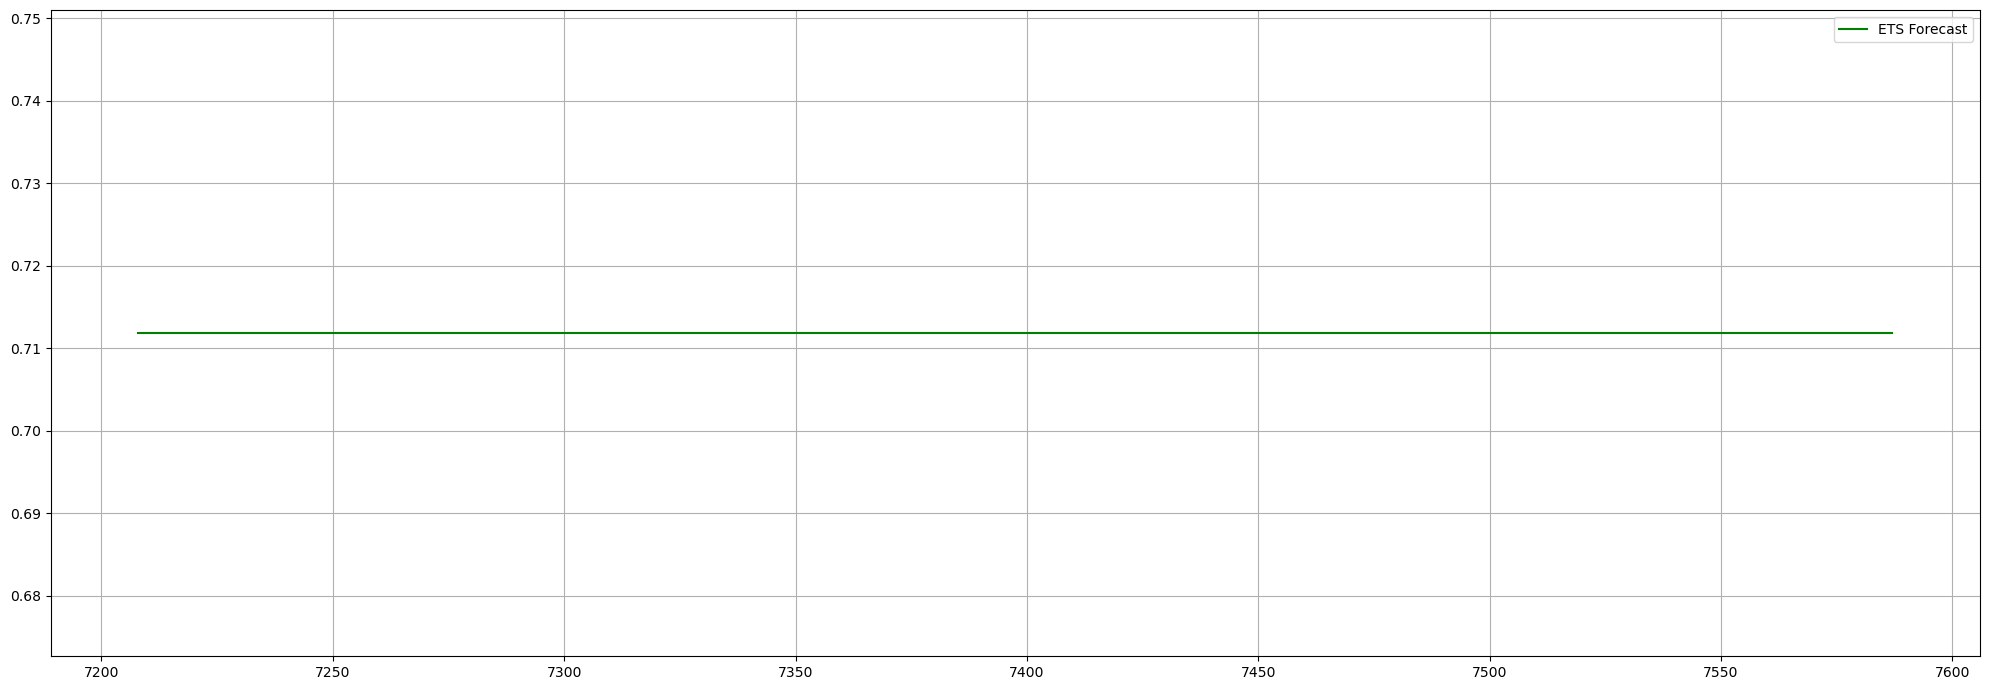

In [63]:
plt.figure(figsize=(20, 7))
plt.plot(es_forecast, label='ETS Forecast', color='green')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
es_mae = mean_absolute_error(actuals, es_forecast.values)
es_rmse = np.sqrt(mean_squared_error(actuals, es_forecast.values))
es_mape = mean_absolute_percentage_error(actuals, es_forecast.values)
print("\nExponential Smoothing Model Metrics:")
print(f"  MAE:  {es_mae:.6f}")
print(f"  RMSE: {es_rmse:.6f}")
print(f"  MAPE: {es_mape:.4f}%")


Exponential Smoothing Model Metrics:
  MAE:  0.033135
  RMSE: 0.037671
  MAPE: 4.3984%


In [69]:
## Exponential Smoothing Model has comparatively less values.Therefore this model is best suitable